# Import Libraris

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torch.nn.init as init

# Basic Parameters

In [54]:
const_V = 25
K = 24
N = 5
T = 200
alpha = 1.5
beta = 0.97
gamma_n_k = 7.35
gamma_n = 15.55

# Load Data

In [55]:
pathN = f"N={N}_energey_game_check"

In [56]:
file_x = f"Numpy_array_save/{pathN}/X_train.npy"
# file_y_sanity = f"Numpy_array_save/{pathN}/Y_train_sanity.npy"
file_z = f"Numpy_array_save/{pathN}/Z_train.npy"
file_y = f"Numpy_array_save/{pathN}/Y_train.npy"

X_train = np.load(file_x)
Y_train = np.load(file_y)
Z_train = np.load(file_z)
# Y_train_sanity = np.load(file_y_sanity)

In [57]:
file_x = f"Numpy_array_save/{pathN}/X_valid.npy"
# file_y_sanity = f"Numpy_array_save/{pathN}/Y_valid_sanity.npy"
file_z = f"Numpy_array_save/{pathN}/Z_valid.npy"
file_y = f"Numpy_array_save/{pathN}/Y_valid.npy"

X_valid = np.load(file_x)
Y_valid = np.load(file_y)
Z_valid = np.load(file_z)
# Y_valid_sanity = np.load(file_y_sanity)

In [58]:
print("### Train ###")
print(f"X Shape: {X_train.shape}")
print(f"Y Shape: {Y_train.shape}")
print(f"Z Shape: {Z_train.shape}")

print("### Valid ###")
print(f"X Shape: {X_valid.shape}")
print(f"Y Shape: {Y_valid.shape}")
print(f"Z Shape: {Z_valid.shape}")
# print(f"Y sanity Shape: {Y_valid_sanity.shape}")

### Train ###
X Shape: (30000, 23)
Y Shape: (30000, 200)
Z Shape: (30000, 400)
### Valid ###
X Shape: (3000, 23)
Y Shape: (3000, 200)
Z Shape: (3000, 400)


# Normalization Process

In [59]:
# Normalize process
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)
print(f"Mean: {X_mean}   STD: {X_std}")

# Normalize data inputs valid and train
epsilon = 1e-6
X_train = (X_train - X_mean) / (X_std + epsilon)
X_valid = (X_valid - X_mean) / (X_std + epsilon)

# Save Xmean and std
# np.save(f"Numpy_array_save/{pathN}/X_mean.npy", X_mean)
# np.save(f"Numpy_array_save/{pathN}/X_std.npy", X_std)

Mean: [5.04609073e+03 5.05531538e+00 2.68382658e+03 4.05531538e+00
 1.44573198e+03 3.25531538e+00 8.25452242e+02 2.65531538e+00
 5.33067435e+02 2.25531538e+00 4.18081475e+02 2.05531538e+00
 4.18081475e+02 2.05531538e+00 5.33067435e+02 2.25531538e+00
 8.25452242e+02 2.65531538e+00 1.44573198e+03 3.25531538e+00
 2.68382658e+03 4.05531538e+00 5.00000000e+00]   STD: [3.15797562e+03 1.12596578e+00 1.83178732e+03 1.12596578e+00
 1.09929296e+03 1.12596578e+00 7.05627135e+02 1.12596578e+00
 5.05093622e+02 1.12596578e+00 4.21094575e+02 1.12596578e+00
 4.21094575e+02 1.12596578e+00 5.05093622e+02 1.12596578e+00
 7.05627135e+02 1.12596578e+00 1.09929296e+03 1.12596578e+00
 1.83178732e+03 1.12596578e+00 0.00000000e+00]


# Build Data to training (Tensors)

In [60]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Z_train = torch.tensor(Z_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)
Z_valid = torch.tensor(Z_valid, dtype=torch.float32)

In [61]:
train_dataset = TensorDataset(X_train, Z_train, Y_train)
val_dataset = TensorDataset(X_valid, Z_valid, Y_valid)

# Define Neural Network Arc.

In [62]:
class Energy_naive(nn.Module):
    def __init__(self, input_size, output_size):
        super(Energy_naive, self).__init__()

        # Define layers
        self.fc0 = nn.Linear(input_size, 256)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, output_size)

        # Initialize weights
        self.init_weights()

    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

# Training Parameters

In [63]:
input_size = X_train.shape[-1]
output_size = 2 # [ak, bk]
print(f"input_size: {input_size}, output_size: {output_size}")

input_size: 23, output_size: 2


In [64]:
# Parameters
num_epochs = 15
batch_size = 128
N = 5 # Number of players|
K = 24 # Number of resources
input_size = X_train.shape[-1]
output_size = output_size
lr_init = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Energy_naive(input_size, output_size).to(device=device)
criterion = nn.MSELoss() # Mean squared error loss
# optimizer = optim.SGD(model.parameters(), lr=lr_init, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = StepLR(optimizer, step_size=10, gamma=1)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Train loop

In [66]:
train_list = []
valid_list = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs_pre, inputs, targets in train_loader:
        # Squeeze the input tensor to match the Fc size
        inputs_pre, inputs, targets = inputs_pre.to(device), inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs_pre)
        # Extract parameters calculate resuidal gradient
        a_k, b_k = outputs[:, 0].view(-1, 1), outputs[:, 1].view(-1, 1)
        Xnk = inputs[:, ::2] # Even indices
        Sk = inputs[:, 1::2]
        # Calculate loss
        prediction = -2 * (a_k * Sk + b_k) * (Sk - Xnk)
        loss = criterion(prediction, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    scheduler.step()  # Update the learning rate

    # Validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs_pre, inputs, targets in val_loader:
            # Squeeze the input tensor to match the Fc size
            inputs_pre, inputs, targets = inputs_pre.to(device), inputs.to(device), targets.to(device)
            outputs = model(inputs_pre)
            # Extract parameters calculate resuidal gradient
            a_k, b_k = outputs[:, 0].view(-1, 1), outputs[:, 1].view(-1, 1)
            Xnk = inputs[:, ::2] # Even indices
            Sk = inputs[:, 1::2]
            # Calculate loss
            prediction = -2 * (a_k * Sk + b_k) * (Sk - Xnk)
            loss = criterion(prediction, targets)
            val_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_list.append(train_loss)
    valid_list.append(val_loss)
    lr_value = optimizer.param_groups[0]["lr"]
    print(f"Epoch [{epoch+1}/{num_epochs}] Learning Rate:{lr_value} - "
          f"Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

Epoch [1/15] Learning Rate:0.001 - Train Loss: 13.49830, Val Loss: 25.29209
Epoch [2/15] Learning Rate:0.001 - Train Loss: 13.34107, Val Loss: 22.36961
Epoch [3/15] Learning Rate:0.001 - Train Loss: 16.54600, Val Loss: 11.57173
Epoch [4/15] Learning Rate:0.001 - Train Loss: 12.83394, Val Loss: 10.21571
Epoch [5/15] Learning Rate:0.001 - Train Loss: 10.92797, Val Loss: 10.14232
Epoch [6/15] Learning Rate:0.001 - Train Loss: 13.46213, Val Loss: 12.92714
Epoch [7/15] Learning Rate:0.001 - Train Loss: 11.90768, Val Loss: 8.65985
Epoch [8/15] Learning Rate:0.001 - Train Loss: 13.12177, Val Loss: 13.34056
Epoch [9/15] Learning Rate:0.001 - Train Loss: 14.22940, Val Loss: 11.25359
Epoch [10/15] Learning Rate:0.001 - Train Loss: 10.97503, Val Loss: 11.10653
Epoch [11/15] Learning Rate:0.001 - Train Loss: 10.57422, Val Loss: 13.69237
Epoch [12/15] Learning Rate:0.001 - Train Loss: 11.80182, Val Loss: 9.13279
Epoch [13/15] Learning Rate:0.001 - Train Loss: 11.73599, Val Loss: 10.61812
Epoch [14/

# Plot Graph train results

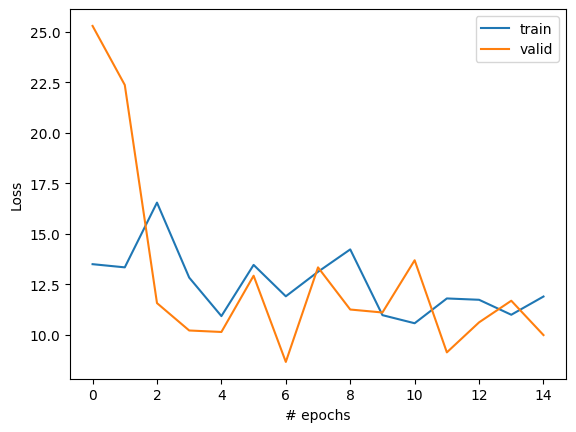

In [67]:
epochs = np.arange(num_epochs)
plt.plot(epochs, train_list, label='train')
plt.plot(epochs, valid_list, label='valid')
plt.xlabel("# epochs"), plt.ylabel("Loss"), plt.legend()
plt.show()

# Plot scatter prediction vs Label

In [68]:
file_x = f"Numpy_array_save/{pathN}/X_valid.npy"
file_y_sanity = f"Numpy_array_save/{pathN}/Y_valid_sanity.npy"

X_valid = np.load(file_x)
Y_sanity_valid = np.load(file_y_sanity)

In [69]:
X_valid = (X_valid - X_mean) / (X_std + epsilon)

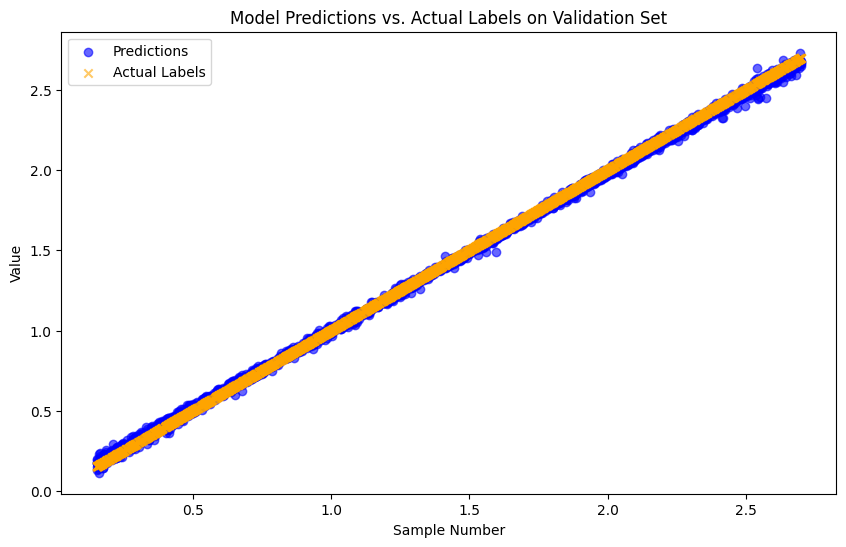

In [70]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    outputs = model(torch.tensor(X_valid,dtype=torch.float32).to(device))
    all_preds.append(outputs.cpu().numpy())
    all_targets.append(Y_sanity_valid)


# Convert lists to arrays
all_preds = np.concatenate(all_preds, axis=0).flatten()
all_targets = np.concatenate(all_targets, axis=0).flatten()


# Plot the predictions vs. actual labels as a scatter plot
jump = 2
plt.figure(figsize=(10, 6))
plt.scatter(all_targets[0:len(all_preds):jump], all_preds[0:len(all_preds):jump], label='Predictions', color='blue', marker='o', alpha=0.6)
plt.scatter(all_targets[0:len(all_preds):jump], all_targets[0:len(all_preds):jump], label='Actual Labels', color='orange', marker='x', alpha=0.6)
plt.xlabel('Sample Number')
plt.ylabel('Value')
plt.title('Model Predictions vs. Actual Labels on Validation Set')
plt.legend()
plt.show()

# Save weights

In [71]:
PATH = './Energy_NetPath(N=5).pth'
torch.save(model.state_dict(), PATH)
print("Finsh")

Finsh
